In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import ResNet28
from time import time
from tqdm.notebook import tqdm
import json
import pickle

# Load Model and Predict Methods

In [35]:
def load_model_only(config):
    path = config.get('model_path', '')
    f = f"{path}/{config['model_identifier']}.pth"
    checkpoint = torch.load(f)
    net = checkpoint['net']
    scaler = checkpoint.get('scaler', None)
    mean_losses = checkpoint['mean_losses']
    return net, scaler, mean_losses

def predict(model, X, y, device='cpu', silent=False):
    pyt_device = torch.device(device)

    if 'cuda' in device:
        # Since it doesn't all fit on the GPU, we'll use a dataloader
        batch_size = 2000
        predictDataset = Dataset(X, y)
        predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=5,
                                                  pin_memory=True
                                                 )
        num_elements = len(predictLoader.dataset)
        num_outputs = len(y.columns)
        num_batches = len(predictLoader)
        predictions = torch.zeros(num_elements, num_outputs)
        for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches, disable=silent):
            inputs = to_device(inputs, pyt_device)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            pred = torch.round(torch.sigmoid(model(inputs)))
            predictions[start:end] = pred.detach().cpu()
        nn_results = predictions.numpy()
    else:
        if type(X) == np.ndarray:
            X_tensor = torch.from_numpy(X).float()
        else:
            X_tensor = torch.from_numpy(X.to_numpy()).float()
        nn_results = torch.round(torch.sigmoid(model(X_tensor))).detach().numpy()

    return nn_results

# Load and Clean Data

In [3]:
def train_test_split(X, y, train_idx=None, test_idx=None):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    return (X_train, y_train, X_test, y_test)

def load_split_data(suffix=None, split=False):
    if suffix==None:
        suffix='DEFAULT'
        
    X = pd.read_pickle(f'../data/X_{suffix}.pkl')
    y = pd.read_pickle(f'../data/y_{suffix}.pkl')
        
    if split:
        X_train, y_train, X_test, y_test = train_test_split(X, y, X.loc[:'2019'].index, X.loc['2020':].index)
        return X_train, y_train, X_test, y_test
    else:
        return X, y
    
X_train, y_train, X_test, y_test = load_split_data(suffix='20210726', split=True)

# Analaze Results

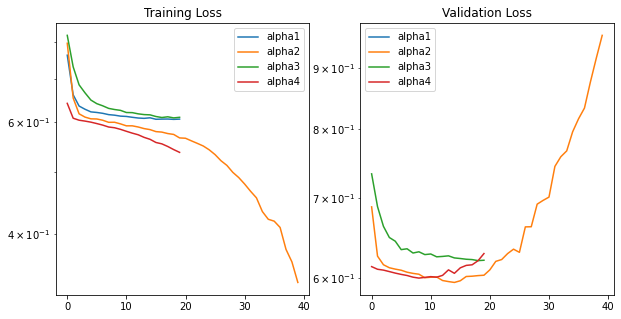

In [51]:
import matplotlib.pyplot as plt

model_ids=[ 'alpha1',
            'alpha2',
            'alpha3',
            'alpha4',
          ]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.set_title("Training Loss")
ax2.set_title("Validation Loss")
    
for model_id in model_ids:
    with open(f'models/{model_id}.cfg') as f:
        configurations = json.load(f)

    _, _, mean_losses = load_model_only(configurations)

    tl, vl = zip(*mean_losses)

    ax1.plot(tl[:40], label=model_id)
    ax2.plot(vl[:40], label=model_id)

# ax1.set_ylim(0,0.02)
# ax2.set_ylim(0,0.02)
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
ax2.legend()
plt.show()

# Precision Analysis

In [52]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision = {}
recall = {}
f1score = {}

for model_id in model_ids:
    with open(f'models/{model_id}.cfg') as f:
        config = json.load(f)

    model, scaler, _ = load_model_only(config)
    
    if scaler is not None:
        X = scaler.transform(X_test.copy())
        scaled_X = X.copy()
    else:
        X = X_test
    
    pred = predict(model, X, y_test, device=config['device'], silent=True)
    pred = np.nan_to_num(pred)
    
    precision[model_id] = round(precision_score(y_test, pred, zero_division=0),4)
    recall[model_id] = round(recall_score(y_test, pred, zero_division=0),4)
    f1score[model_id] = round(f1_score(y_test, pred, zero_division=0),4)

metrics = pd.DataFrame({k: [v,recall[k],f1score[k]] for k,v in precision.items()}, index=['precision','recall','f1']).T
metrics.plot(kind='barh', stacked=True, figsize=(6,len(metrics)))
plt.gca().invert_yaxis()